In [15]:
from binance.client import Client
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import plotly.graph_objects as go

######################## Print method
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

######################## Initialize Binance Futures client
client = Client()
symbol = "BTCUSDT"
interval = '1m'      ####### Time interval for candles
limit = 40           ####### Rolling window size

######################## Fetch bid and ask volume using aggregate trades
def get_agg_trade_volume(symbol, start_time, end_time):
    trades = client.futures_aggregate_trades(
        symbol=symbol,
        startTime=start_time,
        endTime=end_time,
        limit=1000
    )
    bid_volume = 0
    ask_volume = 0
    for trade in trades:
        if trade['m']: 
            ask_volume += float(trade['q'])
        else:
            bid_volume += float(trade['q'])
    return bid_volume, ask_volume

##################################### Initialize historical data using futures lines for live updates
def fetch_initial_data():
    candles = client.futures_klines(symbol=symbol, interval=interval, limit=limit)
    volume_data = []
    time_data = []
    for candle in candles:
        start_time = candle[0]
        end_time = start_time + 60_000
        bid_vol, ask_vol = get_agg_trade_volume(symbol, start_time, end_time)
        volume_data.append([bid_vol, ask_vol])
        time_data.append(pd.to_datetime(start_time, unit='ms') + pd.Timedelta(hours=5, minutes=30))
    df = pd.DataFrame(volume_data, columns=['bid_volume', 'ask_volume'], index=time_data)
    df.index.name = 'Time (IST)'
    return df

########################## Regime detection logic (both mean and clustering)
def detect_regime(df):
    df = df.copy()
    df['total_vol'] = df['bid_volume'] + df['ask_volume']

    if len(df) >= 20:
        df['total_vol_20avg'] = df['total_vol'].rolling(window=20).mean().shift(1) ## previous 20 candles
        df['is_volatile_rollavg'] = df['total_vol'] > df['total_vol_20avg']        ## volatile if current total volume is greater than the rolling average
        df['regime_mean'] = df['is_volatile_rollavg'].apply(lambda x: 'volatile' if x else 'stable')
        df['mean_method'] = df['is_volatile_rollavg'].astype(int)
    else:
        df['total_vol_20avg'] = np.nan
        df['regime_mean'] = 'unknown'
        df['mean_method'] = -1

    ###################### Apply clustering only if we have at least 2 rows, even i am using different machine learning models, but the logic above this is 
    ###################### really good for volatile and stable regims
    if len(df) >= 2:
        try:
            model = AgglomerativeClustering(n_clusters=2, linkage='complete', metric='manhattan')
            df['cluster'] = model.fit_predict(df[['bid_volume', 'ask_volume']])
            volatile_cluster = df.groupby('cluster')['total_vol'].mean().idxmax()
            df['regime_cluster'] = df['cluster'].apply(lambda x: 'volatile' if x == volatile_cluster else 'stable')
        except Exception as e:
            print("Clustering failed:", e)
            df['cluster'] = -1
            df['regime_cluster'] = 'unknown'
    else:
        df['cluster'] = -1
        df['regime_cluster'] = 'unknown'

    return df


######################### Live updating function
def fetch_latest_candle_and_update(df):
    try:
        candles = client.futures_klines(symbol=symbol, interval=interval, limit=1)
        latest = candles[-1]
        start_time = latest[0]
        end_time = start_time + 60_000
        time_ist = pd.to_datetime(start_time, unit='ms') + pd.Timedelta(hours=5, minutes=30)

        # Avoid duplicate timestamps
        if time_ist in df.index:
            print(f"Data for {time_ist} already exists. Skipping.")
            return df

        bid_vol, ask_vol = get_agg_trade_volume(symbol, start_time, end_time)

        # Create and append new row
        new_row = pd.DataFrame({
            'bid_volume': [bid_vol],
            'ask_volume': [ask_vol]
        }, index=[time_ist])
        new_row.index.name = 'Time (IST)'
        df = pd.concat([df, new_row])
        df = df.tail(limit)

        # Recompute regimes
        df = detect_regime(df)

        print(f"Updated with new data for {time_ist}")
        return df
    except Exception as e:
        print("Error during update:", e)
        return df

########### Plot function for clustering results(Just for check somthing good or bad)
# def plot_hidden_states(hidden_states, df):
#     colors = ['blue', 'green', 'red', 'orange', 'purple']
#     fig = go.Figure()
#     n_components = len(np.unique(hidden_states))

#     for i in range(n_components):
#         mask = hidden_states == i
#         fig.add_trace(go.Scatter(
#             x=df.index[mask],
#             y=df['bid_volume'][mask],
#             mode='markers',
#             name=f'Bid Volume State {i}',
#             marker=dict(size=6, color=colors[i % len(colors)])
#         ))
#         fig.add_trace(go.Scatter(
#             x=df.index[mask],
#             y=df['ask_volume'][mask],
#             mode='markers',
#             name=f'Ask Volume State {i}',
#             marker=dict(size=4, color=colors[i % len(colors)], symbol='triangle-up'),
#             opacity=0.6
#         ))

#     fig.update_layout(
#         height=500, width=900,
#         title="Market Regime Clustering - Bid & Ask Volumes",
#         xaxis_title="Time (IST)",
#         yaxis_title="Volume",
#         legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
#         margin=dict(l=20, r=20, t=40, b=20)
#     )
#     fig.show()



####################### Get signal

def get_signal(df: pd.DataFrame) -> str:
    if len(df) < 2:
        return 'hold'  # Not enough data for signal

    prev_candle = df.iloc[-2]
    curr_candle = df.iloc[-1]

    # Signal only if both candles are marked as 'volatile'
    if prev_candle['regime_mean'] == 'volatile' and curr_candle['regime_mean'] == 'volatile':
        if curr_candle['bid_volume'] > curr_candle['ask_volume']:
            return 'buy'
        elif curr_candle['ask_volume'] > curr_candle['bid_volume']:
            return 'sell'
        else:
            return 'hold'
    else:
        return 'hold'



###################################Some global variables for order management
open_positions = []  # Store open positions
max_positions = 2    # Maximum number of open positions
risk_amount = 100    # Amount to risk per trade
tp_multiplier = 1.5  # Take profit multiplier based on ATR
sl_multiplier = 1.0  # Stop loss multiplier based on ATR
leverage = 10        # Leverage for futures trading
atr = 0.02           # ATR value for calculating TP/SL (using as a point, I am fixed this (i can change it))
############################## place an order 
async def place_order(exchange, signal: str, price: float, atr: float, symbol: str):
    try:
        if len(open_positions) >= max_positions:
            logger.info("Max positions reached, skipping new order.")
            return

        qty = risk_amount / price

        if signal == 'buy':
            order = await exchange.create_market_buy_order(symbol, qty)
            tp_price = price + tp_multiplier * atr
            sl_price = price - sl_multiplier * atr
            open_positions.append({
                'symbol': symbol,
                'side': 'long',
                'entry_price': price,
                'quantity': qty,
                'tp_price': tp_price,
                'sl_price': sl_price
            })
            logger.info(f"Placed long order: {order}")

        elif signal == 'sell':
            order = await exchange.create_market_sell_order(symbol, qty)
            tp_price = price - tp_multiplier * atr
            sl_price = price + sl_multiplier * atr
            open_positions.append({
                'symbol': symbol,
                'side': 'short',
                'entry_price': price,
                'quantity': qty,
                'tp_price': tp_price,
                'sl_price': sl_price
            })
            logger.info(f"Placed short order: {order}")

        else:
            logger.info("Signal was 'hold'. No order placed.")

    except Exception as e:
        logger.error(f"Error placing order: {e}")
        return None


# ################### MAIN EXECUTION
# df = fetch_initial_data()
# df = detect_regime(df)
# # plot_hidden_states(df['cluster'].values, df)

# #################### Start live updates
# print("Starting live update every minute...")
# while True:
#     df = fetch_latest_candle_and_update(df)
#     print(df[['bid_volume', 'ask_volume', 'total_vol', 'regime_mean', 'regime_cluster']].tail(20))
#     time.sleep(60)  # wait for next candle


In [16]:
import asyncio
import ccxt.async_support as ccxt_async

async def main():
    df = fetch_initial_data()
    df = detect_regime(df)

    # Setup ccxt exchange
    exchange = ccxt_async.binance({
        'apiKey': 'Xsbs4NqyjzYf4qTAQAqG68AbKN1yJw9wePUftd1VjITfWil404RbZEDxvrriCk33',
        'secret': 'nHNnM7mhcTyslTQThZhD06neCyAahzi0nxW3RlreNpW7NiFj62hMusyLeiERvgmw',
        'enableRateLimit': True,
        'options': {'defaultType': 'future'},
    })

    print("Running live bot...")
    try:
        while True:
            df = fetch_latest_candle_and_update(df)
            df = detect_regime(df)

            signal = get_signal(df)
            print(f"Signal: {signal}")

            # Fetch market price
            ticker = await exchange.fetch_ticker(symbol)
            price = ticker['last']

            # Place order based on signal
            await place_order(exchange, signal, price, atr, symbol)

            print(df[['bid_volume', 'ask_volume', 'total_vol', 'regime_mean', 'regime_cluster']].tail(20))

            await asyncio.sleep(60)

    except Exception as e:
        logger.error(f"Main loop error: {e}")
    finally:
        await exchange.close()



In [17]:
# Run the bot
if __name__ == "__main__":
    await main()

Running live bot...
Data for 2025-06-11 15:57:00 already exists. Skipping.
Signal: hold


2025-06-11 15:57:47,205 - INFO - Signal was 'hold'. No order placed.


                     bid_volume  ask_volume  total_vol regime_mean  \
Time (IST)                                                           
2025-06-11 15:38:00     124.829      27.154    151.983    volatile   
2025-06-11 15:39:00      20.383      31.398     51.781      stable   
2025-06-11 15:40:00      13.113      24.012     37.125      stable   
2025-06-11 15:41:00      14.102      18.630     32.732      stable   
2025-06-11 15:42:00       5.526      40.078     45.604      stable   
2025-06-11 15:43:00      30.700      19.255     49.955      stable   
2025-06-11 15:44:00      14.809      12.986     27.795      stable   
2025-06-11 15:45:00      18.101      28.603     46.704      stable   
2025-06-11 15:46:00      17.126      21.264     38.390      stable   
2025-06-11 15:47:00      22.938      15.070     38.008      stable   
2025-06-11 15:48:00      14.712      26.133     40.845      stable   
2025-06-11 15:49:00      18.902      16.286     35.188      stable   
2025-06-11 15:50:00 

2025-06-11 15:58:48,467 - INFO - Signal was 'hold'. No order placed.


                     bid_volume  ask_volume  total_vol regime_mean  \
Time (IST)                                                           
2025-06-11 15:39:00      20.383      31.398     51.781      stable   
2025-06-11 15:40:00      13.113      24.012     37.125      stable   
2025-06-11 15:41:00      14.102      18.630     32.732      stable   
2025-06-11 15:42:00       5.526      40.078     45.604      stable   
2025-06-11 15:43:00      30.700      19.255     49.955      stable   
2025-06-11 15:44:00      14.809      12.986     27.795      stable   
2025-06-11 15:45:00      18.101      28.603     46.704      stable   
2025-06-11 15:46:00      17.126      21.264     38.390      stable   
2025-06-11 15:47:00      22.938      15.070     38.008      stable   
2025-06-11 15:48:00      14.712      26.133     40.845      stable   
2025-06-11 15:49:00      18.902      16.286     35.188      stable   
2025-06-11 15:50:00       4.957      19.867     24.824      stable   
2025-06-11 15:51:00 

CancelledError: 

### Data collection

In [ ]:
from binance.client import Client
import pandas as pd
import time
from datetime import datetime, timedelta

# Initialize Binance Futures client
client = Client()

#start_time and end_time in milliseconds
#This function fetches total traded volume
def get_agg_trades(symbol, start_time, end_time):
    
    trades = []
    while start_time < end_time:
        batch = client.futures_aggregate_trades(   #Fetch aggregate trades
            symbol=symbol,
            startTime=start_time,
            endTime=end_time,
            limit=1000                     #max allowed trades in one request
        )
        if not batch:
            break
        trades.extend(batch)               #store the trades
        last_trade_time = batch[-1]['T']   #last trade time
        start_time = last_trade_time + 1   #start time
        time.sleep(0.1)                    # To prevent rate limits
    return trades


###seprate the bid and ask volume from the trades
def process_trades_to_volume_df(trades, interval='1min'):
    
    records = []
    for trade in trades:
        ts = pd.to_datetime(trade['T'], unit='ms')       #data frame timestamp
        qty = float(trade['q'])                          #Total quantity traded in 1min
        is_buyer_maker = trade['m']                      #m -> buy maker flag
        bid_volume = qty if is_buyer_maker else 0        #bid
        ask_volume = qty if not is_buyer_maker else 0    #ask
        records.append({                                 
            'timestamp': ts,
            'bid_volume': bid_volume,
            'ask_volume': ask_volume
        })

    df = pd.DataFrame(records)                           #data frame
    df.set_index('timestamp', inplace=True)              #set index to timestamp
    df = df.resample(interval).sum().fillna(0)           #Resample is  important for interval(add every bid/ask volume in 1min)
    df['total_volume'] = df['bid_volume'] + df['ask_volume']
    return df

# === USER PARAMETERS ===
symbol = 'BTCUSDT'
start_date = '2025-05-01 03:00:00'
end_date   = '2025-05-01 04:00:00'
interval = '1min'

# === TIME CONVERSION ===
start_ts = int(pd.to_datetime(start_date).timestamp() * 1000)
end_ts = int(pd.to_datetime(end_date).timestamp() * 1000)

# === FETCH AND PROCESS ===
print("Downloading aggregate trades...")
agg_trades = get_agg_trades(symbol, start_ts, end_ts)
print(f" Fetched {len(agg_trades)} trades.")

print("Aggregating volumes...")
volume_df = process_trades_to_volume_df(agg_trades, interval=interval)

# === EXPORT ===
volume_df.to_csv(f'{symbol}_bid_ask_volume_{interval}_3_4.csv')
print(volume_df.head())


 Fetched 31531 trades.
Aggregating volumes...
                     bid_volume  ask_volume  total_volume
timestamp                                                
2025-05-01 03:00:00      39.490     102.023       141.513
2025-05-01 03:01:00      23.984      24.626        48.610
2025-05-01 03:02:00      11.028       9.296        20.324
2025-05-01 03:03:00      16.129      34.640        50.769
2025-05-01 03:04:00      23.514       9.632        33.146


## Websocket

In [ ]:
import websocket
import json
import pandas as pd
from datetime import datetime
from threading import Thread
import time

symbol = 'btcusdt'
interval = '1min'

# Data storage
records = []

# Convert aggTrade to volume record
def process_trade(trade):
    ts = pd.to_datetime(trade['T'], unit='ms')
    qty = float(trade['q'])
    is_buyer_maker = trade['m']
    bid_volume = qty if is_buyer_maker else 0
    ask_volume = qty if not is_buyer_maker else 0
    records.append({
        'timestamp': ts,
        'bid_volume': bid_volume,
        'ask_volume': ask_volume
    })

def on_message(ws, message):
    trade = json.loads(message)
    process_trade(trade)

def on_error(ws, error):
    print(f"Error: {error}")

def on_close(ws, close_status_code, close_msg):
    print("WebSocket closed.")

def on_open(ws):
    print("WebSocket connection opened.")

def start_websocket():
    stream_url = f"wss://fstream.binance.com/ws/{symbol}@aggTrade"
    ws = websocket.WebSocketApp(stream_url,
                                on_open=on_open,
                                on_message=on_message,
                                on_error=on_error,
                                on_close=on_close)
    ws.run_forever()

# Start WebSocket in a separate thread
ws_thread = Thread(target=start_websocket)
ws_thread.start()

# Let it run for desired duration
run_minutes = 2    
print(f"Collecting live aggTrade data for {run_minutes} minute(s)...")
time.sleep(run_minutes * 60)

# Stop the websocket after collecting data
print("Stopping WebSocket data collection.")
# You may force close manually or add logic to stop cleanly

# Process collected records into DataFrame
df = pd.DataFrame(records)
df.set_index('timestamp', inplace=True)
df = df.resample(interval).sum().fillna(0)
df['total_volume'] = df['bid_volume'] + df['ask_volume']

# Export
output_file = f'{symbol.upper()}_live_bid_ask_volume_{interval}.csv'
df.to_csv(output_file)
print(df.head())


WebSocket connection opened.
Stopping WebSocket data collection.
                     bid_volume  ask_volume  total_volume
timestamp                                                
2025-06-11 10:38:00       3.514      18.767        22.281
2025-06-11 10:39:00       8.536       6.006        14.542
2025-06-11 10:40:00       9.475       0.467         9.942


### Backtest

Performance Metrics:
Sharpe Ratio        : -59.31
Sortino Ratio       : -39.48
Max Drawdown        : -5.10%
CAGR                : -100.00%
Annualized Volatility: 132.62%


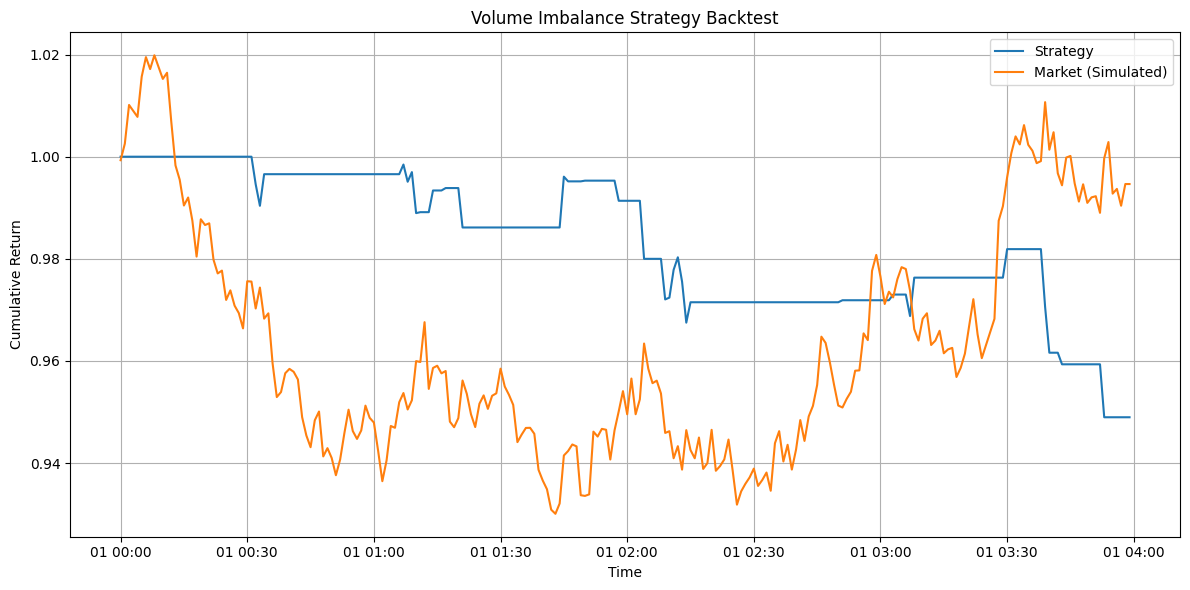

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load historical data
df = pd.read_csv('C:/Users/Mritunjay Maddhesiya/OneDrive/Desktop/c++STL/A++/Statical_Trading/1/BTCUSDT_bid_ask_volume_1min.csv', parse_dates=['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
df.set_index('timestamp', inplace=True)

# Calculate total volume
df['total_vol'] = df['bid_volume'] + df['ask_volume']

# Regime detection using rolling average
df['total_vol_20avg'] = df['total_vol'].rolling(window=20).mean().shift(1)
df['is_volatile_rollavg'] = df['total_vol'] > df['total_vol_20avg']
df['regime_mean'] = np.where(df['is_volatile_rollavg'], 'volatile', 'stable')

# Signal generation
df['signal'] = 'hold'
volatile = (df['regime_mean'].shift(1) == 'volatile') & (df['regime_mean'] == 'volatile')
df.loc[volatile & (df['bid_volume'] > df['ask_volume']), 'signal'] = 'buy'
df.loc[volatile & (df['ask_volume'] > df['bid_volume']), 'signal'] = 'sell'

# Simulate price (replace with real prices if available)
np.random.seed(42)
df['price'] = 100 + np.cumsum(np.random.normal(0, 0.5, len(df)))

# Calculate returns
df['return'] = df['price'].pct_change().shift(-1)
df['strategy_return'] = df['return'] * df['signal'].map({'buy': 1, 'sell': -1, 'hold': 0})

# Cumulative returns
df['cumulative_strategy'] = (1 + df['strategy_return'].fillna(0)).cumprod()
df['cumulative_market'] = (1 + df['return'].fillna(0)).cumprod()

# ----------------------------------
# 🔢 Performance Metrics Calculation
# ----------------------------------

# Sharpe Ratio
risk_free_rate = 0.0
strategy_ret = df['strategy_return'].dropna()
sharpe_ratio = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252*24*60)  # 1-min bars

# Maximum Drawdown
cumulative = df['cumulative_strategy'].fillna(1)
rolling_max = cumulative.cummax()
drawdown = cumulative / rolling_max - 1
max_drawdown = drawdown.min()

# CAGR
days = (df.index[-1] - df.index[0]).total_seconds() / (60*60*24)
years = days / 365.25
cagr = (cumulative.iloc[-1])**(1 / years) - 1 if years > 0 else np.nan

# Volatility
volatility = strategy_ret.std() * np.sqrt(252*24*60)

# Sortino Ratio (using downside std deviation)
downside_std = strategy_ret[strategy_ret < 0].std()
sortino_ratio = (strategy_ret.mean() / downside_std) * np.sqrt(252*24*60) if downside_std > 0 else np.nan

# -------------------
# 📋 Print Metrics
# -------------------
print("Performance Metrics:")
print(f"Sharpe Ratio        : {sharpe_ratio:.2f}")
print(f"Sortino Ratio       : {sortino_ratio:.2f}")
print(f"Max Drawdown        : {max_drawdown:.2%}")
print(f"CAGR                : {cagr:.2%}")
print(f"Annualized Volatility: {volatility:.2%}")

# -------------------
# 📈 Plot Results
# -------------------
plt.figure(figsize=(12,6))
plt.plot(df.index, df['cumulative_strategy'], label='Strategy')
plt.plot(df.index, df['cumulative_market'], label='Market (Simulated)')
plt.legend()
plt.title("Volume Imbalance Strategy Backtest")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()


Performance Metrics:
Sharpe Ratio         : -2.09
Sortino Ratio        : -3.39
Max Drawdown         : -1.73%
CAGR                 : -98.84%
Annualized Volatility: 114.90%


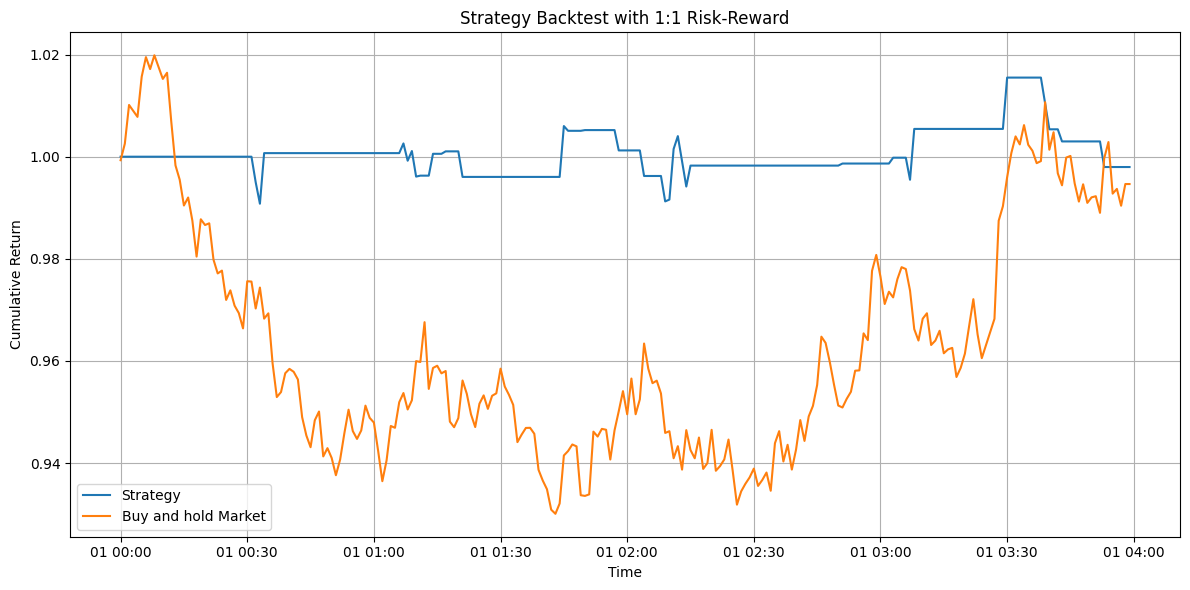

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load historical data
df = pd.read_csv('C:/Users/Mritunjay Maddhesiya/OneDrive/Desktop/c++STL/A++/Statical_Trading/1/BTCUSDT_bid_ask_volume_1min.csv', parse_dates=['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
df.set_index('timestamp', inplace=True)

# Calculate total volume
df['total_vol'] = df['bid_volume'] + df['ask_volume']

# Regime detection using rolling average
df['total_vol_20avg'] = df['total_vol'].rolling(window=20).mean().shift(1)
df['is_volatile_rollavg'] = df['total_vol'] > df['total_vol_20avg']
df['regime_mean'] = np.where(df['is_volatile_rollavg'], 'volatile', 'stable')

# Signal generation: Only in volatile regime for two consecutive bars
df['signal'] = 'hold'
volatile = (df['regime_mean'].shift(1) == 'volatile') & (df['regime_mean'] == 'volatile')
df.loc[volatile & (df['bid_volume'] > df['ask_volume']), 'signal'] = 'buy'
df.loc[volatile & (df['ask_volume'] > df['bid_volume']), 'signal'] = 'sell'

# Simulate price: Replace this with your actual price data if available
np.random.seed(42)
df['price'] = 100 + np.cumsum(np.random.normal(0, 0.5, len(df)))

# Parameters for risk-reward
risk_pct = 0.005  # 0.5% risk per trade

# Initialize returns list
strategy_returns = []

for i in range(1, len(df) - 1):
    signal = df['signal'].iloc[i]
    if signal == 'hold':
        strategy_returns.append(0)
        continue

    entry_price = df['price'].iloc[i]
    risk = entry_price * risk_pct

    next_price = df['price'].iloc[i + 1]

    if signal == 'buy':
        stop_loss = entry_price - risk
        take_profit = entry_price + 1 * risk

        if next_price <= stop_loss:
            ret = -risk / entry_price  # Loss (negative return)
        elif next_price >= take_profit:
            ret = 2 * risk / entry_price  # Gain (positive return)
        else:
            ret = (next_price - entry_price) / entry_price  # Partial move

    elif signal == 'sell':
        stop_loss = entry_price + risk
        take_profit = entry_price - 1 * risk

        if next_price >= stop_loss:
            ret = -risk / entry_price
        elif next_price <= take_profit:
            ret = 2 * risk / entry_price
        else:
            ret = (entry_price - next_price) / entry_price
    else:
        ret = 0

    strategy_returns.append(ret)

# Padding first and last returns with zero (no trade)
strategy_returns = [0] + strategy_returns + [0]

df['strategy_return'] = strategy_returns
df['return'] = df['price'].pct_change().shift(-1).fillna(0)  # market return for comparison

# Calculate cumulative returns
df['cumulative_strategy'] = (1 + df['strategy_return']).cumprod()
df['cumulative_market'] = (1 + df['return']).cumprod()

# Performance metrics calculation
strategy_ret = df['strategy_return']
trading_periods_per_year = 252 * 24 * 60  # assuming 1-min bars, 252 trading days, 24h trading

sharpe_ratio = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(trading_periods_per_year)

cumulative = df['cumulative_strategy']
rolling_max = cumulative.cummax()
drawdown = cumulative / rolling_max - 1
max_drawdown = drawdown.min()

days = (df.index[-1] - df.index[0]).total_seconds() / (60 * 60 * 24)
years = days / 365.25
cagr = (cumulative.iloc[-1]) ** (1 / years) - 1 if years > 0 else np.nan

volatility = strategy_ret.std() * np.sqrt(trading_periods_per_year)
downside_std = strategy_ret[strategy_ret < 0].std()
sortino_ratio = (strategy_ret.mean() / downside_std) * np.sqrt(trading_periods_per_year) if downside_std > 0 else np.nan

# Print metrics
print("Performance Metrics:")
print(f"Sharpe Ratio         : {sharpe_ratio:.2f}")
print(f"Sortino Ratio        : {sortino_ratio:.2f}")
print(f"Max Drawdown         : {max_drawdown:.2%}")
print(f"CAGR                 : {cagr:.2%}")
print(f"Annualized Volatility: {volatility:.2%}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['cumulative_strategy'], label='Strategy')
plt.plot(df.index, df['cumulative_market'], label='Buy and hold Market')
plt.legend()
plt.title("Strategy Backtest with 1:1 Risk-Reward")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()
